# This notebook reports the process of exploratory data analysis and identify/engineer important features for detecting fraudulent transactions

You will see I perform the EDA and feature engineering pretty carefully below because I believe simple ML models can perform very well if we incorporate business logic of the data. My philosophy for this is simple > complex. The work in this project is inspired by my own experience and a case from Amazon (I hope the story was true :D):
- My experience: I have worked with anomaly detection on time series for almost 3 years. Till now, 100+ models have been proposed in literature and the people keep working on that and they want domain-anogstic models (i.e., just throw data into models and wait for the results). Tested on my data, those models were not useful at all and I developed another by myself and this is simple and it outperformed 40 SOTA. The secret is I incorporated the knowledge of the data I am working on to the decision-making process.
- For Amazon (https://www.linkedin.com/posts/janaboerger_datainlogistics-logistics-machinelearning-activity-7275523299177107456-SDya/): long story short, two interns hired to work on the same project. One spent the whole time understanding business logic of the data, and the other was eager to jump into throwing the data to fancy deep learning models. The first guy just used simple ML models and outperformed DL models by a large margin.

Now let's jump in the EAD process and how I engineered features in that way. Later, I hope you will be impressed about the results I have achieved based on the engineered-data on very simple ML models I have built.

In [1]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

In [2]:
import glob
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import utils
from sklearn.preprocessing import LabelEncoder
import pickle

### Data Loading

In [3]:
df = utils.load_data(nonfraud_path=glob.glob("datasets/*_nonfraud_*.csv"), fraud_path=glob.glob("datasets/*_fraud*.csv"))
df.timestamp = pd.to_datetime(df.timestamp)
df = df.sort_values('timestamp')

df

,id,sender_id,receiver_id,amount,status,flowname,bankfees,timestamp,sender_age,receiver_age,fraud
171236,5c8151de80789d810adffd2ad6c6d73e,f867461ddbde7fa46dd79da1ebb931b7,aa0164889106c53610a04ae00cccfc1c,11.0,PaymentSucceededV0,6fed08d35288c5c3571085571e34c7c1,0.0,2024-05-13 07:43:57.565976+00:00,15,15,0
94287,90b30bc7689ac1b1f01fc1b76b241e17,45786a5076562ea244057adc59e41e44,8bacdbeefc8781aee27e45abc550d91a,200.0,PaymentSucceededV0,233046f509c582591ff83d0915e07895,0.0,2024-05-13 07:43:58.287183+00:00,18,26,0
171237,e47bcec76ce7fdfb495ccee208faf714,7f4d2cabec48f7c3868dd59613a814e1,8a730fe5b046ca5426b0b03bcae1a6a8,136.0,PaymentSucceededV0,e395101288f53121cee2480bc7f24c4b,0.0,2024-05-13 07:43:58.472749+00:00,44,41,0
94288,3468a6acbf03452cf1725ffc5cb53cab,7d94b0c2986b1a60bd4e0c31945cc951,efe1d73780f3720e8d7a599aa2c8612a,190.0,PaymentSucceededV0,233046f509c582591ff83d0915e07895,0.0,2024-05-13 07:43:58.484421+00:00,38,38,0
171238,eb7027331b7324db8635e364ea8ff934,201dde1c7ac1d44cc064cba82ece279d,3394c539f03529e3692562af38a1a376,16.0,PaymentSucceededV0,6fed08d35288c5c3571085571e34c7c1,0.0,2024-05-13 07:43:58.794077+00:00,17,18,0
...,...,...,...,...,...,...,...,...,...,...,...
70,de8efe7c02d565efbf6a3e1ba966a568,9cde10a283f4c0e7d47d5e872e2a757d,68875fb5ba57030e9ecfeb674649217d,4600.0,PaymentSucceededV0,233046f509c582591ff83d0915e07895,0.0,2024-06-24 19:07:33.709995+00:00,77,42,1
94,b4a3679623887aa236fe69567daf6d27,9cde10a283f4c0e7d47d5e872e2a757d,68875fb5ba57030e9ecfeb674649217d,4600.0,PaymentSucceededV0,233046f509c582591ff83d0915e07895,0.0,2024-06-24 19:08:46.995678+00:00,77,42,1
71,deca5e00cdfe11de14b4558b7b019956,9cde10a283f4c0e7d47d5e872e2a757d,68875fb5ba57030e9ecfeb674649217d,4600.0,PaymentSucceededV0,233046f509c582591ff83d0915e07895,0.0,2024-06-24 19:11:46.860648+00:00,77,42,1
69,49f3f8fb4b9720a08c5c57940487c6fd,9cde10a283f4c0e7d47d5e872e2a757d,68875fb5ba57030e9ecfeb674649217d,4600.0,PaymentSucceededV0,233046f509c582591ff83d0915e07895,0.0,2024-06-24 19:12:19.466062+00:00,77,42,1


In [4]:
print('''We first check null cells.
As I can see, only bankfees are null when payments are failed. 
Bankfees are important later to calculate zscore of some features, so I impute this column now with 0.''')

df = df.fillna(0)

We first check null cells.
As I can see, only bankfees are null when payments are failed. 
Bankfees are important later to calculate zscore of some features, so I impute this column now with 0.


In [5]:
df.isnull().sum()

id              0
sender_id       0
receiver_id     0
amount          0
status          0
flowname        0
bankfees        0
timestamp       0
sender_age      0
receiver_age    0
fraud           0
dtype: int64

### Analyzing data distribution

In [6]:
print('We try to see the percentage of fraud transcations in the whole dataset')
print(f'The percentage of fraud transactions in the dataset is {len(df[df.fraud == 1]) / len(df) * 100}% \
        \nand the total number of fraud transactions is {len(df[df.fraud == 1])}')

We try to see the percentage of fraud transcations in the whole dataset
The percentage of fraud transactions in the dataset is 0.006178174737889344%         
and the total number of fraud transactions is 97


#### Observation
This indicates that the data is extremely skewed and we must think of the following:
- <b>Resembling techniques:</b>
  - Oversampling: to increase the number of fraud samples by generating synthetic samples.
  - Undersampling: to reduce the number of non-fraud samples to match with fraud samples.

- <b>Use class weights while training ML models</b>: This is a must to consider.
- <b>Perform anomaly detection</b>: We can treat fraud transactions as anomalies. Given the fact that anomalies account for less than 1% of the data [1][2], this appears as a very suitable approach. This is also my expertise as my PhD focuses on this topic &#x1F600;.

- <b>Evaluation metrics</b>: Distinguishing fraud and non-fraud transactions is basically a binary classification problem. There are a few we can think of the following: F1, AUC-ROC, or AUC-PR. I prefer to use AUC-PR and below are some reasonsings:

   - F1: this can give good scores to ML models even if anomalies are missed and we don't want it! In addition, it's senstive to thresholds. A small change in the threshold can result in significant difference. It's sometimes difficult to come up with a reasonable threshold and we have to frequently adjust thresholds due to concept drift (i.e., unexpected data distribution changes - one of my ML project is about this [3]).
   - AUC-ROC: although this metric is independent from thresholds (see F1). A major drawback of AUC-ROC is it can give good scores to ML models that have high TNR (True Negative Rate) and low TPR (True Positive Rate). *We clearly don't want it because we want to identify as many positives (fraud transactions) as possible!*
   - AUC-PR: same to AUC-ROC, this is independent from thresholds (+1). In addition, it focuses on positive class (in our case, fraud transactions).
   - For more details, you can look at [3] ([2] can be a good resource).

- Anyway, first, we try to explore the data.

References:

[1] Wu, R. and Keogh, E.J., 2021. Current time series anomaly detection benchmarks are flawed and are creating the illusion of progress. IEEE transactions on knowledge and data engineering, 35(3), pp.2421-2429. https://arxiv.org/pdf/2009.13807 

[2] Sebastian Schmidl, Phillip Wenig, and Thorsten Papenbrock. Anomaly Detection in Time Series: A Comprehensive Evaluation. PVLDB, 15(9): 1779 - 1797, 2022. doi:10.14778/3538598.3538602. https://dl.acm.org/doi/10.14778/3538598.3538602 

[3] Nguyen, N.T., Heldal, R. and Pelliccione, P., 2024. Concept-drift-adaptive anomaly detector for marine sensor data streams. Internet of Things, p.101414. https://www.sciencedirect.com/science/article/pii/S254266052400355X


### Analyze potential differences between fraud and non-fraud transactions of numeric features

In [7]:
fraud_df = df[df.fraud == 1]
nonfraud_df = df[df.fraud == 0]

In [8]:
fraud_df.describe().T

,count,mean,std,min,25%,50%,75%,max
amount,97.0,2445.206186,2520.382589,10.0,900.0,900.0,4600.0,18000.0
bankfees,97.0,154.639175,1071.313506,0.0,0.0,0.0,0.0,7500.0
sender_age,97.0,72.041237,8.432227,43.0,71.0,76.0,76.0,84.0
receiver_age,97.0,40.113402,11.605383,17.0,40.0,40.0,40.0,79.0
fraud,97.0,1.000000,0.000000,1.0,1.0,1.0,1.0,1.0


In [9]:
nonfraud_df.describe().T

,count,mean,std,min,25%,50%,75%,max
amount,1569946.0,334.446046,1068.477788,0.01,35.0,100.0,300.0,250000.0
bankfees,1569946.0,1.834458,111.437909,0.00,0.0,0.0,0.0,7500.0
sender_age,1569946.0,37.438986,17.736751,11.00,22.0,34.0,50.0,99.0
receiver_age,1569946.0,32.872929,16.072488,11.00,19.0,28.0,44.0,97.0
fraud,1569946.0,0.000000,0.000000,0.00,0.0,0.0,0.0,0.0


In [10]:
numeric_features = ['amount', 'bankfees', 'sender_age', 'receiver_age']
print(f'We first focus on numeric feature of the data: {numeric_features}')

We first focus on numeric feature of the data: ['amount', 'bankfees', 'sender_age', 'receiver_age']


In [11]:
print('We try to see if the numeric features are significant for fraud prediction; if not, we can drop some')

from scipy import stats

nonfraud_df.dropna(inplace=True)
fraud_df.dropna(inplace=True)

# Perform t-test features between nonfraud and fraud
for feature in numeric_features:
    t_stat, p_val = stats.ttest_ind(nonfraud_df[feature], fraud_df[feature])
    print(f"{feature}: T-statistic: {t_stat}, P-value: {p_val}")

print('---------------------')
print('''Explanations and insights: Bigger T-statistic values (in both directions) indicate differences between two groups. 
Smaller P-values indicate how unlikely the differences are because of random chance. 
Here we see that the means of these factors for fraudulent transactions are smaller than those of legitimate 
and they happen for good reasons. We can conclude that these features are significant for the detection and thus being kept.''')

We try to see if the numeric features are significant for fraud prediction; if not, we can drop some
amount: T-statistic: -19.452939882012235, P-value: 2.8157154699903623e-84
bankfees: T-statistic: -13.466843446609602, P-value: 2.4642436933424293e-41
sender_age: T-statistic: -19.213788127841944, P-value: 2.900419522743857e-82
receiver_age: T-statistic: -4.436726096799178, P-value: 9.134359092632519e-06
---------------------
Explanations and insights: Bigger T-statistic values (in both directions) indicate differences between two groups. 
Smaller P-values indicate how unlikely the differences are because of random chance. 
Here we see that the means of these factors for fraudulent transactions are smaller than those of legitimate 
and they happen for good reasons. We can conclude that these features are significant for the detection and thus being kept.


In [12]:
print('We try to see how much outliers of each feature detected')

def iqr_detection(feature):
    Q1 = df[feature].quantile(0.25)
    Q3 = df[feature].quantile(0.75)
    IQR = Q3 - Q1
    outliers = df[(df[feature] < (Q1 - 1.5 * IQR)) | (df[feature] > (Q3 + 1.5 * IQR))]
    return outliers

for feature in numeric_features:
    outliers = iqr_detection(feature)
    print(f'With {feature}, {len(outliers[outliers.fraud == 1]) / len(fraud_df) * 100}% and {len(outliers[outliers.fraud == 0]) / len(nonfraud_df) * 100}% of fraud and NON-fraud transactions identified as outliers with IQR test')

print('---------------------')
print('''Observations: almost all fraudulent transactions related to anomalous amounts, 
which can be further confirmed in the boxplot below. 
You can see that fraudulent transactions involve transactions with reasonably money bigger than the norm.''')

We try to see how much outliers of each feature detected
With amount, 95.87628865979381% and 10.631894345410608% of fraud and NON-fraud transactions identified as outliers with IQR test
With bankfees, 2.0618556701030926% and 0.03019212125767383% of fraud and NON-fraud transactions identified as outliers with IQR test
With sender_age, 0.0% and 0.027325780631945306% of fraud and NON-fraud transactions identified as outliers with IQR test
With receiver_age, 0.0% and 0.22930725005828229% of fraud and NON-fraud transactions identified as outliers with IQR test
---------------------
Observations: almost all fraudulent transactions related to anomalous amounts, 
which can be further confirmed in the boxplot below. 
You can see that fraudulent transactions involve transactions with reasonably money bigger than the norm.


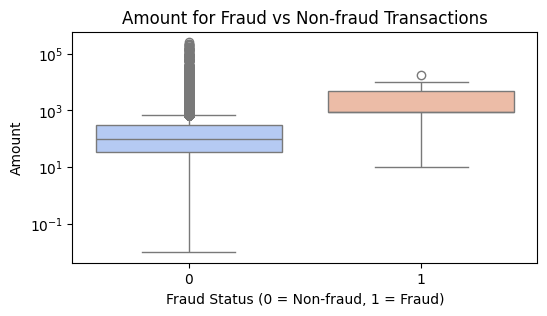

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 3))
sns.boxplot(x='fraud', y='amount', data=df, palette='coolwarm')
plt.title('Amount for Fraud vs Non-fraud Transactions')
plt.xlabel('Fraud Status (0 = Non-fraud, 1 = Fraud)')
plt.ylabel('Amount')
plt.yscale('log')  
plt.show()


In [14]:
print('Then, we can engineer a new feature like in the code')
feature = 'amount'
Q1 = df[feature].quantile(0.25)
Q3 = df[feature].quantile(0.75)
IQR = Q3 - Q1
outliers = df[(df[feature] < (Q1 - 1.5 * IQR)) | (df[feature] > (Q3 + 1.5 * IQR))]
df['amount_outlier'] = ((df['amount'] < (Q1 - 1.5 * IQR)) | (df['amount'] > (Q3 + 1.5 * IQR))).astype(int)

Then, we can engineer a new feature like in the code


We will try to see some additional insights by checking boxplot of each feature


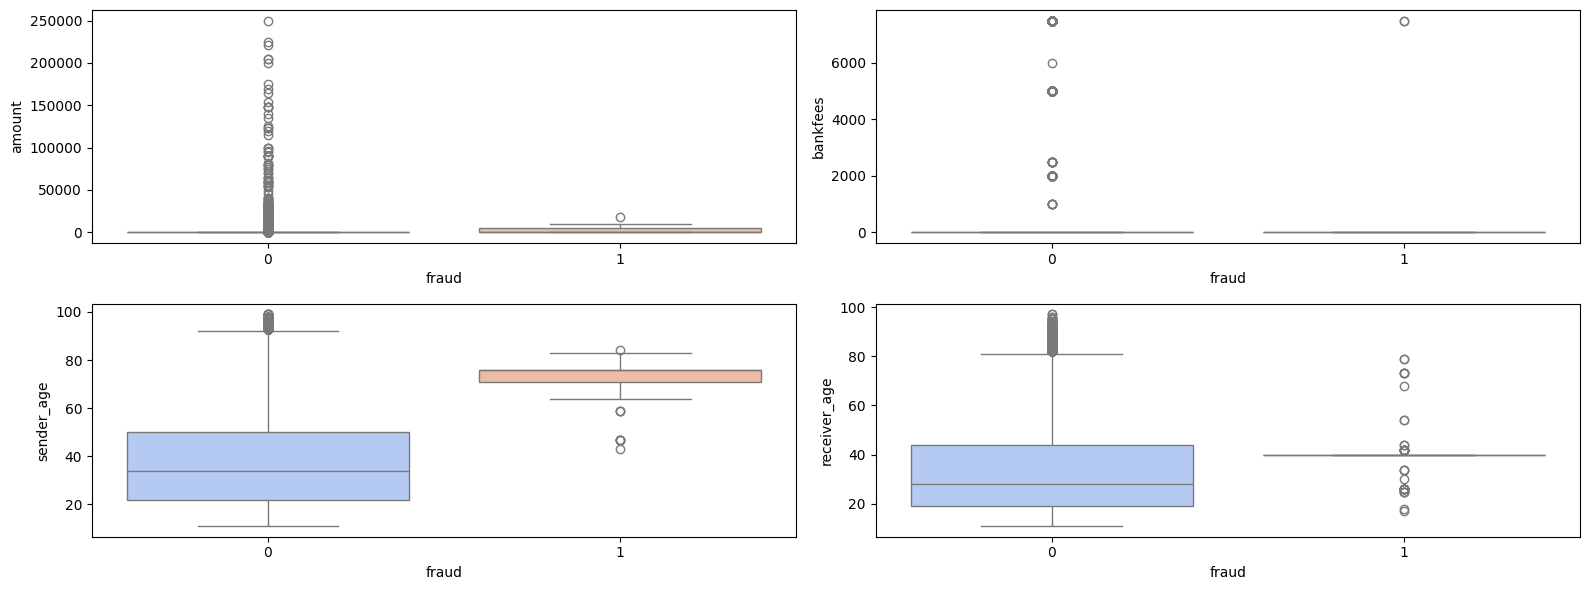

In [15]:
print('We will try to see some additional insights by checking boxplot of each feature')

fig, axes = plt.subplots(2, 2, figsize=(16, 6))

for i in range(len(numeric_features)):
    combined_df = pd.concat([nonfraud_df[[numeric_features[i], 'fraud']], fraud_df[[numeric_features[i], 'fraud']]])
    sns.boxplot(x='fraud', y=numeric_features[i], data=combined_df, ax=axes[i // 2, i % 2], palette='coolwarm')

plt.tight_layout()
plt.show()


Additional insights extracted from these plots:
- amount: We can see non-fraudulent transactions have a few extremely high values (outliers). We can say large transaction amounts are less likely to be fraudulent. Fraudulent transactions (fraud=1) tend to have smaller amounts, mostly clustered around a low value (but still higher than the norm - see above). 
- bankfees: Same pattern between both categories - cannot conclude anything for now. I also checked the data manually, only two fraudulent transactions having high bank fee. Given the fact that the distribution of bankfees is different b/w fraudulent and legitimate transactions (see above), better to keep this feature.
- sender_age: Older people tend to involve in fraudulent activities - aligning with Olga problem (later you will see these people are retired).
- receiver_age: Median of fraudulent transactions tend to be higher.

In [16]:
print('Because of these patterns, we can engineer some additional features indicating anomalous degrees')

df['amount_zscore'] = (df['amount'] - df['amount'].mean()) / df['amount'].std()
df['sender_age_zscore'] = (df['sender_age'] - df['sender_age'].mean()) / df['sender_age'].std()
df['receiver_age_zscore'] = (df['receiver_age'] - df['receiver_age'].mean()) / df['receiver_age'].std()

Because of these patterns, we can engineer some additional features indicating anomalous degrees


We will now see the correlations between each pair of features


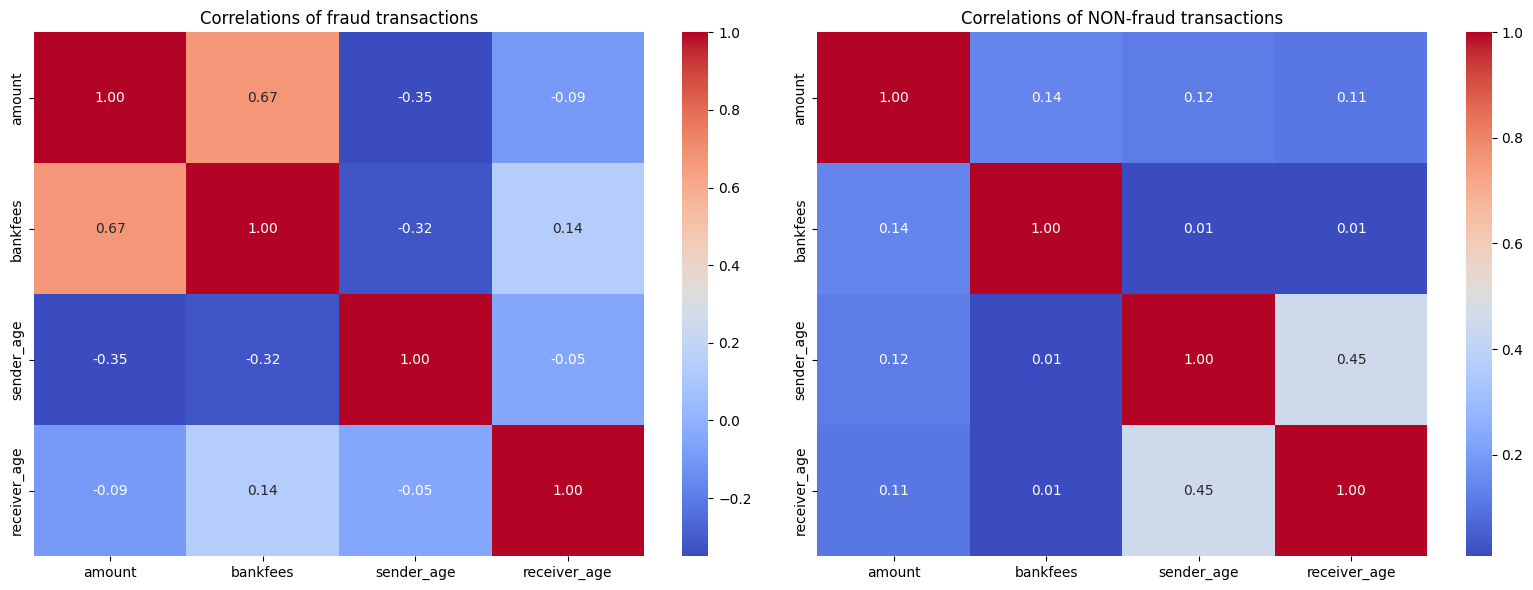

In [17]:
print('We will now see the correlations between each pair of features')

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.heatmap(fraud_df[numeric_features].corr(), annot=True, fmt='.2f', cmap='coolwarm', ax=axes[0])
axes[0].set_title('Correlations of fraud transactions')
sns.heatmap(nonfraud_df[numeric_features].corr(), annot=True, fmt='.2f', cmap='coolwarm', ax=axes[1])
axes[1].set_title('Correlations of NON-fraud transactions')

plt.tight_layout()
plt.show()


<b>Observations:</b> we see significant differences regarding correlations of numeric features when it comes to fraud vs. NON-fraud transactions:
- bankfees vs. amount: In fraud transactions, there's a more significant positive relationship between these two factors, while in nonfraud, this correlation is weak. Perhaps, more substantial transactions were done for fraudulent activites?
- sender_age vs. amount/bankfees: Younsters tend to involve big money fraudulent transactions. For legitimate ones, this factor is weak.
- receiver_age vs. sender_age: more significant social or generational trend can be observed for non-fraud transactions (0.45), while this is weak for fraudulent ones.
  
<b>Things to take into account:</b>
- Fradulent transactions typically involving younger senders with high amounts of transactions.
- Bankfees for fradulent transactions tend to be higher, as well. 
- Legitimate transactions tend to follow social clusters - old people have more contact with elderly. In contrast, fraud transactions seem to lack such consistent patterns.

In [18]:
print('''With those observations, we can engineer the following features''')
# Transaction amount vs. ages of senders and receivers
df["amount_zscore_sender_age"] = (
    df["amount"] - df.groupby("sender_age")["amount"].transform("mean")
) / df.groupby("sender_age")["amount"].transform("std")
df["amount_zscore_receiver_age"] = (
    df["amount"] - df.groupby("receiver_age")["amount"].transform("mean")
) / df.groupby("receiver_age")["amount"].transform("std")

# Transaction fees vs. ages of senders and receivers
df["bankfees_zscore_sender_age"] = (
    df["bankfees"] - df.groupby("sender_age")["bankfees"].transform("mean")
) / df.groupby("sender_age")["bankfees"].transform("std")
df["bankfees_zscore_sender_age"] = df["bankfees_zscore_sender_age"].fillna(0)
df["bankfees_zscore_receiver_age"] = (
    df["bankfees"] - df.groupby("receiver_age")["bankfees"].transform("mean")
) / df.groupby("receiver_age")["bankfees"].transform("std")
df["bankfees_zscore_receiver_age"] = df["bankfees_zscore_receiver_age"].fillna(0)

# Fee per transaction
df['fee_per_transaction'] = df['bankfees'] / df['amount']

# Ages between senders and receivers
df["sender_age_zscore_receiver_age"] = (
    df["sender_age"] - df.groupby("receiver_age")["sender_age"].transform("mean")
) / df.groupby("receiver_age")["sender_age"].transform("std")

With those observations, we can engineer the following features


### Extract additional insights by analyzing non-numeric features

#### Social circle of people

In [19]:
print('''We try to see social circle of those involved in fraudulent activities.
Older people (interestingly, most of them are retired!) tend to send money to younger people in fraudulent transactions.
In addition, those who involved in fraudulent activities usually contact (send money from one to another.''')

fraud_df['age_diff_sender_receiver'] = fraud_df['sender_age'] - fraud_df['receiver_age']
fraud_df[['sender_id', 'sender_age', 'receiver_id', 'receiver_age', 'age_diff_sender_receiver']].value_counts().reset_index()

We try to see social circle of those involved in fraudulent activities.
Older people (interestingly, most of them are retired!) tend to send money to younger people in fraudulent transactions.
In addition, those who involved in fraudulent activities usually contact (send money from one to another.


,sender_id,sender_age,receiver_id,receiver_age,age_diff_sender_receiver,count
0,a8d88604449da4bbe0b318923b6d860e,76,68a1ba743df5ea66c42e2e4337d7127a,40,36,53
1,fc433312de4e737ae51af34058f0f3ff,65,325b277f8cfc402a3e62c93bf8d63574,26,39,11
2,9cde10a283f4c0e7d47d5e872e2a757d,77,68875fb5ba57030e9ecfeb674649217d,42,35,10
3,88b995024fb9ee5307d9e11f41b73d25,64,35ed2aaaf83404bd7b515070e7ace6a9,73,-9,4
4,bf4e0bcc86b0aa817117d8db33b57fc6,72,0f3e32ae5e31bf5a59bd7e2a478ae67f,25,47,4
5,357496362b816d37e3bba786b8f8b2c5,47,917152af08683f090e57780f7e864077,34,13,3
6,391e8609f6b62b2f0ea88e1a5f95428c,83,d548d56705a5d6b05bd17cb76e6885ba,54,29,2
7,57ba12761fc02fbd9bb3591add512606,59,8a0196a0aa7dfddb3be27a6fa9186ef7,79,-20,2
8,efc63a1a319fde7cab79d698259bfeef,47,78b49cd329657ed9a2c8f8bb7eb72c2e,44,3,2
9,13cfa12c02b69a5013a43c9aa6ebf3d4,84,4a1c1702d56e493ba499c7b94be7d71f,17,67,1


In [20]:
print('''We will see people involving in legitimate transactions sent money that often - clearly not!''')

nonfraud_df[['sender_id', 'sender_age', 'receiver_id', 'receiver_age']].value_counts().reset_index()

We will see people involving in legitimate transactions sent money that often - clearly not!


,sender_id,sender_age,receiver_id,receiver_age,count
0,43b5a45e079439c3e589e33a3d265a5f,21,43b5a45e079439c3e589e33a3d265a5f,21,41
1,6e2ec7eb565f7bbade4a926a5fb9d451,24,f8adb281091423ed5299898811cedead,22,31
2,0e5798df3d508ad73064bfb6fcdbe1be,30,3ec1104507478d6b862681118d9fbb61,30,30
3,5d4c3cef401289517e0ed3cd05096d34,19,16313794580284fe15e271541056abeb,17,26
4,2cced10fd0eddc30b37057ddec35b7e8,18,714f40effadf92e562d1081c2fb130a4,43,25
...,...,...,...,...,...
1428257,5891863667c90b39839ef7dbb7253407,17,1db321d2d6ce30a6cc2f01efbe0a7c77,18,1
1428258,58917e13601d3e75e00dabdc2bd3bcaf,38,20058bcfe14beea9db3884cb3447f999,11,1
1428259,58916de7ee4ac010122a64c3c8596d8b,18,a3b78b08ade7fcd65a84b2e72f5e6b74,21,1
1428260,58915b5198a3786a83d6e26c03e9ad42,16,f1c413cde83f990e53cf15d9497b0b26,16,1


As you can see, age difference is a significant feature that can distinguish between fraud and non-fraud transactions


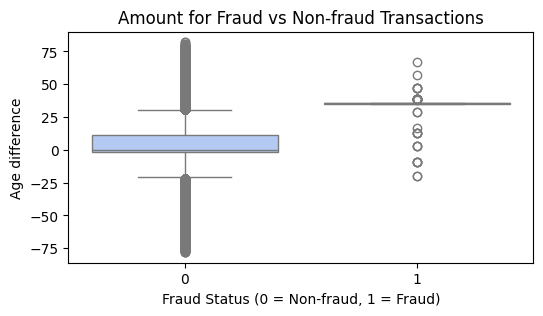

In [21]:
print('As you can see, age difference is a significant feature that can distinguish between fraud and non-fraud transactions')

df['age_diff_sender_receiver'] = df['sender_age'] - df['receiver_age']
plt.figure(figsize=(6, 3))
sns.boxplot(x='fraud', y='age_diff_sender_receiver', data=df, palette='coolwarm')
plt.title('Amount for Fraud vs Non-fraud Transactions')
plt.xlabel('Fraud Status (0 = Non-fraud, 1 = Fraud)')
plt.ylabel('Age difference')
plt.show()

In [22]:
print('It would be interesting to keep track the number of times each pair of people has transferred money')
df["transaction_frequency"] = df.groupby(["sender_id", "receiver_id"]).cumcount()

It would be interesting to keep track the number of times each pair of people has transferred money


In [23]:
print('''We will check some outliers now - younger (not too young) to older.
We can observe some close transactions (timestamp, I mean) involved.
This is our next feature engineering target.''')

fraud_df[fraud_df.age_diff_sender_receiver < 0]

We will check some outliers now - younger (not too young) to older.
We can observe some close transactions (timestamp, I mean) involved.
This is our next feature engineering target.


,id,sender_id,receiver_id,amount,status,flowname,bankfees,timestamp,sender_age,receiver_age,fraud,age_diff_sender_receiver
73,01ca49ea2f89f380d05b0daaf96ba340,88b995024fb9ee5307d9e11f41b73d25,35ed2aaaf83404bd7b515070e7ace6a9,4000.0,PaymentSucceededV0,06a380d2a2da7b3c0553297dd2b6c18c,0.0,2024-06-06 07:02:38.966166+00:00,64,73,1,-9
72,205b32de36522e2aa3fc8689934349f1,88b995024fb9ee5307d9e11f41b73d25,35ed2aaaf83404bd7b515070e7ace6a9,400.0,PaymentSucceededV0,06a380d2a2da7b3c0553297dd2b6c18c,0.0,2024-06-06 07:03:34.229887+00:00,64,73,1,-9
75,18a42cf12fb6825d6bc11f962a9fef87,88b995024fb9ee5307d9e11f41b73d25,35ed2aaaf83404bd7b515070e7ace6a9,100.0,PaymentSucceededV0,06a380d2a2da7b3c0553297dd2b6c18c,0.0,2024-06-06 07:04:19.371104+00:00,64,73,1,-9
74,d9f1c7b35656d481c382d0896adc0423,88b995024fb9ee5307d9e11f41b73d25,35ed2aaaf83404bd7b515070e7ace6a9,10000.0,PaymentSucceededV0,06a380d2a2da7b3c0553297dd2b6c18c,7500.0,2024-06-07 16:10:41.883386+00:00,64,73,1,-9
68,a6ee9ef778b140a0a7073fd175354907,57ba12761fc02fbd9bb3591add512606,8a0196a0aa7dfddb3be27a6fa9186ef7,2000.0,PaymentSucceededV0,06a380d2a2da7b3c0553297dd2b6c18c,0.0,2024-06-22 19:01:47.549376+00:00,59,79,1,-20
78,4363ccbfd0ccd8ad9c046e84968de5e4,57ba12761fc02fbd9bb3591add512606,8a0196a0aa7dfddb3be27a6fa9186ef7,1000.0,PaymentSucceededV0,06a380d2a2da7b3c0553297dd2b6c18c,0.0,2024-06-22 19:02:35.473180+00:00,59,79,1,-20


#### Timestamp of transactions

As you can see, people involve in fraudulent activities send money in shorter time


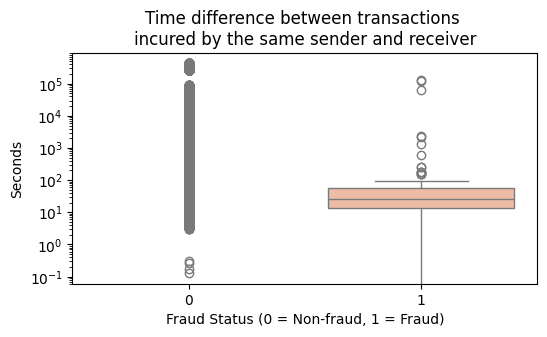

In [24]:
df = df.reset_index()
df['transaction_time_diff'] = (
    df.sort_values('timestamp')
    .groupby(['sender_id', 'receiver_id'])['timestamp']
    .diff()
)
df['transaction_time_diff'] = df['transaction_time_diff'].dt.total_seconds()
df['transaction_time_diff'] = df['transaction_time_diff'].fillna(0)

print('As you can see, people involve in fraudulent activities send money in shorter time')

plt.figure(figsize=(6, 3))
sns.boxplot(x='fraud', y='transaction_time_diff', data=df, palette='coolwarm')
plt.title('Time difference between transactions \nincured by the same sender and receiver')
plt.xlabel('Fraud Status (0 = Non-fraud, 1 = Fraud)')
plt.ylabel('Seconds')
plt.yscale('log')
plt.show()


We will now see when in the day fraudulent transactions tend to happen.
We can see fraudulent transactions tend to occur after business hours.
We can ignore minute and second, as they are too detailed to care.


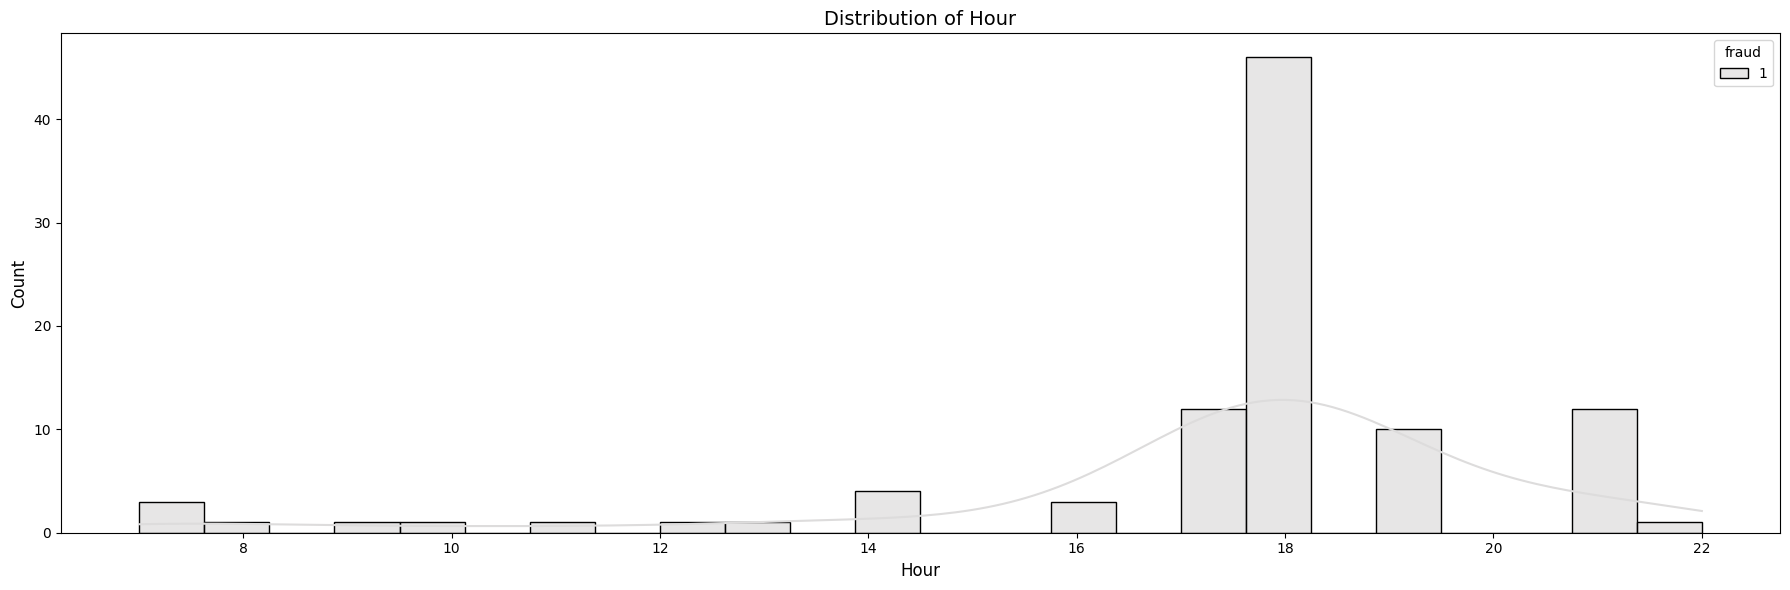

In [25]:
print('''We will now see when in the day fraudulent transactions tend to happen.
We can see fraudulent transactions tend to occur after business hours.
We can ignore minute and second, as they are too detailed to care.''')

df['hour'] = df['timestamp'].dt.hour

time_features = ['hour']#, 'minute', 'second']

# Create subplots
fig, axes = plt.subplots(1, len(time_features), figsize=(18, 6))

for i, feature in enumerate(time_features):
    sns.histplot(
        data=df[df.fraud==1], 
        x=feature, 
        hue='fraud', 
        bins=24 if feature == 'hour' else 60, 
        palette='coolwarm', 
        alpha=0.7, 
        kde=True,  # Add KDE for smooth distribution curve
        ax=axes
    )
    axes.set_title(f'Distribution of {feature.capitalize()}', fontsize=14)
    axes.set_xlabel(f'{feature.capitalize()}', fontsize=12)
    axes.set_ylabel('Count', fontsize=12)
    #axes[i].legend(title='Fraud', loc='upper right')

# Adjust layout
plt.tight_layout()
plt.show()



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


We can see fraudulent transactions tend to occur at the middle of the week.


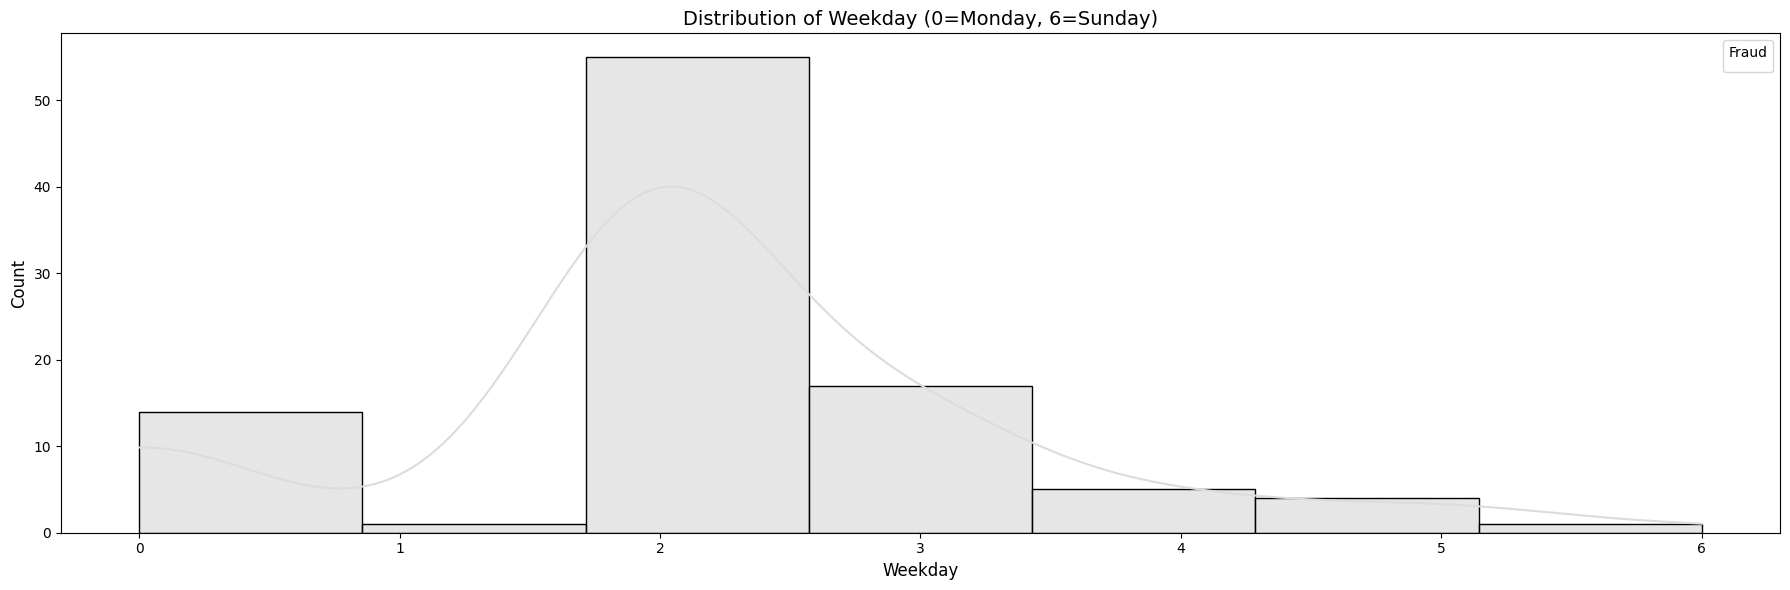

In [26]:
print('We can see fraudulent transactions tend to occur at the middle of the week.')

# Extract the day of the week (0=Monday, 6=Sunday)
df['weekday'] = df['timestamp'].dt.weekday
time_features = ['weekday']

# Create subplots
fig, axes = plt.subplots(1, len(time_features), figsize=(18, 6))

for i, feature in enumerate(time_features):
    sns.histplot(
        data=df[df.fraud==1], 
        x=feature, 
        hue='fraud', 
        bins=7, 
        palette='coolwarm', 
        alpha=0.7, 
        kde=True,  # Add KDE for smooth distribution curve
        ax=axes
    )
    axes.set_title(f'Distribution of {feature.capitalize()} (0=Monday, 6=Sunday)', fontsize=14)
    axes.set_xlabel(f'{feature.capitalize()}', fontsize=12)
    axes.set_ylabel('Count', fontsize=12)
    axes.legend(title='Fraud', loc='upper right')

# Adjust layout
plt.tight_layout()
plt.show()




We will now see fraudulent transactions tend to happen toward the end of the month 
and for me, this is a significant feature because:
1) we are focusing on Olga fraud scheme thats involve people try to exploit welfare system
2) we already know that old (and retired) people involve in this kind of activity,
3) to my knowledge (with some googling efforts), in Norway, pension money is paid on the 20th of each month, 
or the day before if the 20th is a Friday
4) this kind of payment takes 1-2 days to Norwegian bank accounts

Given the fact that pension money is paid monthly, then month can be considered in case we have more data


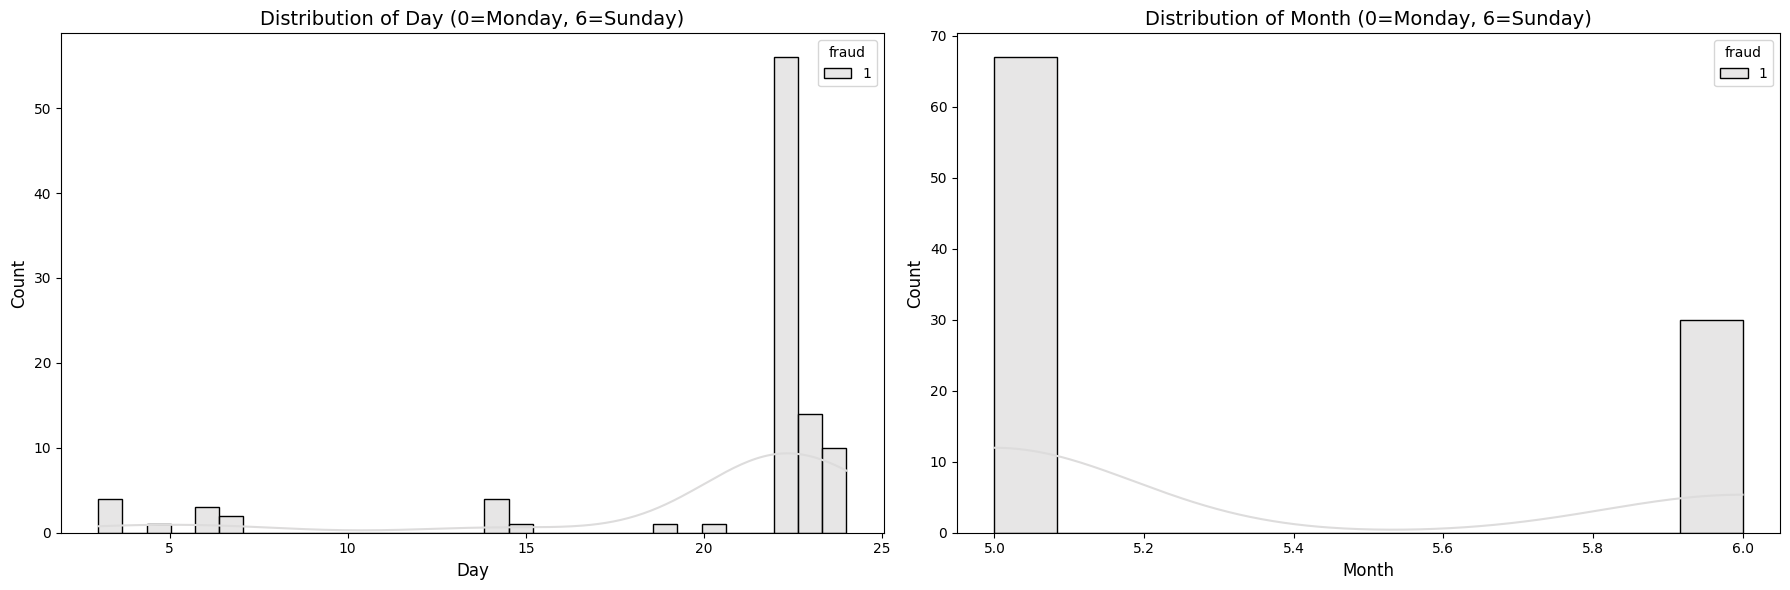

In [27]:
print('''
We will now see fraudulent transactions tend to happen toward the end of the month 
and for me, this is a significant feature because:
1) we are focusing on Olga fraud scheme thats involve people try to exploit welfare system
2) we already know that old (and retired) people involve in this kind of activity,
3) to my knowledge (with some googling efforts), in Norway, pension money is paid on the 20th of each month, 
or the day before if the 20th is a Friday
4) this kind of payment takes 1-2 days to Norwegian bank accounts

Given the fact that pension money is paid monthly, then month can be considered in case we have more data''')

df['day'] = df['timestamp'].dt.day
df['month'] = df['timestamp'].dt.month

time_features = ['day', 'month']

# Create subplots
fig, axes = plt.subplots(1, len(time_features), figsize=(18, 6))
num_bins = {'day': 31, 'month': 12, 'year': 20}

for i, feature in enumerate(time_features):
    sns.histplot(
        data=df[df.fraud==1], 
        x=feature, 
        hue='fraud', 
        bins=num_bins[feature], 
        palette='coolwarm', 
        alpha=0.7, 
        kde=True,  # Add KDE for smooth distribution curve
        ax=axes[i]
    )
    axes[i].set_title(f'Distribution of {feature.capitalize()} (0=Monday, 6=Sunday)', fontsize=14)
    axes[i].set_xlabel(f'{feature.capitalize()}', fontsize=12)
    axes[i].set_ylabel('Count', fontsize=12)
    #axes[i].legend(title='Fraud', loc='upper right')

# Adjust layout
plt.tight_layout()
plt.show()



It can be interesting to see how long fraudulent transactions happen after the pension money is paid.
For simplicity, I assume that the money takes one day to arrive at the account.
We also confirm if the person in question is already retired (>= 67 years old).
-----------------------
Now, we can distinguish between fraudulent and legitimate transactions


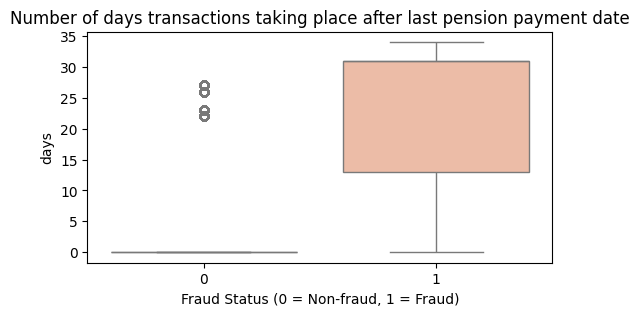

In [28]:
print('''It can be interesting to see how long fraudulent transactions happen after the pension money is paid.
For simplicity, I assume that the money takes one day to arrive at the account.
We also confirm if the person in question is already retired (>= 67 years old).''')

df['is_pension'] = (df['sender_age'] >= 67).astype(int)

# A function to calculate pay date of pension money
# Basically, it happens on the 20th day of the month if day of the transaction is after 20
# Or 20th day of the previous month otherwise
def calculate_pension_pay_day(date):
    # Move the date to the previous month
    previous_month = date - pd.offsets.MonthBegin(2)  
    pay_day = previous_month.replace(day=20)  
    
    # Check if the 20th is a Friday
    if pay_day.weekday() == 4:  # 0=Monday, 4=Friday
        # If Friday, adjust to the day before (Thursday)
        pay_day = pay_day - pd.Timedelta(days=1)
    
    return pay_day

df['last_pension_pay_date'] = df['timestamp'].apply(calculate_pension_pay_day)
df['pensionpaid_transaction_days_diff'] = (df['timestamp'] - df['last_pension_pay_date']).dt.days - 1
df['pensionpaid_transaction_days_diff'] = df['pensionpaid_transaction_days_diff'] * df['is_pension']
df.drop('last_pension_pay_date', axis=1, inplace=True)

print('-----------------------')
print('Now, we can distinguish between fraudulent and legitimate transactions')

plt.figure(figsize=(6, 3))
sns.boxplot(x='fraud', y='pensionpaid_transaction_days_diff', data=df, palette='coolwarm')
plt.title('Number of days transactions taking place after last pension payment date')
plt.xlabel('Fraud Status (0 = Non-fraud, 1 = Fraud)')
plt.ylabel('days')
#plt.yscale('log')
plt.show()


#### Status of transactions

In [29]:
print('''As we can see, there are two types of transaction status. Fraudulent transactions always succeeded. 
However, we try to see if those involving in fraudulent activities have failed payments.''')

df.status.value_counts().reset_index()

As we can see, there are two types of transaction status. Fraudulent transactions always succeeded. 
However, we try to see if those involving in fraudulent activities have failed payments.


,status,count
0,PaymentSucceededV0,1529023
1,PaymentFailedV0,41020


In [30]:
df.groupby('status')['fraud'].sum().reset_index()

,status,fraud
0,PaymentFailedV0,0
1,PaymentSucceededV0,97


In [31]:
print('''Not that many, but let's see if they somehow relate to fraudulent transactions.
As we can see money is transferred from the old to the young.
Some senders have several failed payments which happened consecutively''')

df[((df.sender_id.isin(fraud_df.sender_id)) | (df.sender_id.isin(fraud_df.receiver_id)) | \
    (df.receiver_id.isin(fraud_df.sender_id)) | (df.receiver_id.isin(fraud_df.receiver_id))) \
    & (df.status == 'PaymentFailedV0')]

Not that many, but let's see if they somehow relate to fraudulent transactions.
As we can see money is transferred from the old to the young.
Some senders have several failed payments which happened consecutively


,index,id,sender_id,receiver_id,amount,status,flowname,bankfees,timestamp,sender_age,...,sender_age_zscore_receiver_age,age_diff_sender_receiver,transaction_frequency,transaction_time_diff,hour,weekday,day,month,is_pension,pensionpaid_transaction_days_diff
152440,120100,dfa0c53452d12b0bcb84e00c57c6b3d2,14879878a0883f0e548bb74998f9d892,9a0e8454c14e4bcfe2c3d51beb0600f3,10.0,PaymentFailedV0,74286088aea0b4fa600e6e2e79c96534,0.0,2024-05-13 16:31:47.879892+00:00,71,...,0.851407,3,0,0.000000,16,0,13,5,1,22
380244,31806,3f10ffb9f206cac56ce4586ef9956f03,68875fb5ba57030e9ecfeb674649217d,6b2211b1e7c71b1eeff5c6b610fa0b4e,6500.0,PaymentFailedV0,06a380d2a2da7b3c0553297dd2b6c18c,0.0,2024-05-17 10:42:14.569362+00:00,42,...,0.042625,1,0,0.000000,10,4,17,5,0,0
425964,58939,1ced6dc22f81a2d2c5f56eafda633a81,1889df6552955c0475cda170756a5be2,f20f8ca80f83a2315f3252283660432e,400.0,PaymentFailedV0,06a380d2a2da7b3c0553297dd2b6c18c,0.0,2024-05-17 10:57:14.110338+00:00,46,...,0.717909,16,0,0.000000,10,4,17,5,0,0
433806,59841,5ce4adaba9d131f271ccdd732387270f,1889df6552955c0475cda170756a5be2,f20f8ca80f83a2315f3252283660432e,400.0,PaymentFailedV0,06a380d2a2da7b3c0553297dd2b6c18c,0.0,2024-05-17 10:59:52.436164+00:00,46,...,0.717909,16,1,158.325826,10,4,17,5,0,0
436400,70048,b3fb6d8e88924b2038a52e8979a2fb8c,1889df6552955c0475cda170756a5be2,f20f8ca80f83a2315f3252283660432e,400.0,PaymentFailedV0,06a380d2a2da7b3c0553297dd2b6c18c,0.0,2024-05-17 11:00:55.090374+00:00,46,...,0.717909,16,2,62.654210,11,4,17,5,0,0
671818,88328,1a9b0e7e3e3349c08384363deaa645ca,68a1ba743df5ea66c42e2e4337d7127a,12a63a08bf77f93867bb77b8c23bd5fa,300.0,PaymentFailedV0,9022a190bcbcd8f1fc2f9f6df8bf1f92,0.0,2024-05-17 13:03:41.602774+00:00,40,...,0.156097,27,0,0.000000,13,4,17,5,0,0
768027,39628,989cf74d506a4f708deddbc24b4776c8,1fab0146c842533aa0759b4e8b91f9cf,68a1ba743df5ea66c42e2e4337d7127a,4300.0,PaymentFailedV0,e395101288f53121cee2480bc7f24c4b,0.0,2024-05-17 14:00:46.658766+00:00,48,...,0.425999,8,0,0.000000,14,4,17,5,0,0


In [32]:
print('''Then, we can engineer a new feature like in the code''')
df['sender_total_failed_transactions'] = (
            df['status'].eq('PaymentFailedV0')  
            .groupby(df['sender_id'])           
            .cumsum()                           
        )

Then, we can engineer a new feature like in the code


We have seen above that people involving in fraudulent activities tried to send money right after a transaction fails.
Now we try to calculate how close people attempt to make a payment after one fails.
-----------------------
As you can see, they attempt to send money almost immediately
For legitimate transactions, the people are more patient.


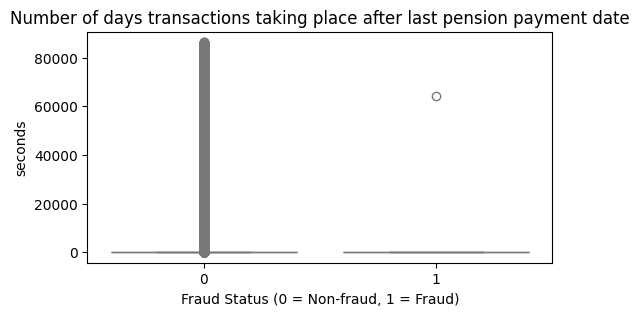

In [33]:
print('''We have seen above that people involving in fraudulent activities tried to send money right after a transaction fails.
Now we try to calculate how close people attempt to make a payment after one fails.''')

failed_payments = df[df['status'] == 'PaymentFailedV0']
merged = pd.merge(df, failed_payments, on='sender_id', suffixes=('', '_failed'), how='left')
merged = merged[merged['timestamp_failed'] < merged['timestamp']]
last_failed_times = merged.groupby(['sender_id', 'timestamp'])['timestamp_failed'].max().reset_index()
df = pd.merge(df, last_failed_times[['sender_id', 'timestamp', 'timestamp_failed']], 
               on=['sender_id', 'timestamp'], 
               how='left')
df['last_failed_time'] = df['timestamp_failed']
df['last_failed_time'].fillna(df['timestamp'], inplace=True)
df['seconds_diff_last_failed'] = (df['timestamp'] - df['last_failed_time']).dt.seconds
df.drop(columns=['timestamp_failed', 'last_failed_time'], inplace=True)

print('-----------------------')
print('''As you can see, they attempt to send money almost immediately
For legitimate transactions, the people are more patient.''')

plt.figure(figsize=(6, 3))
sns.boxplot(x='fraud', y='seconds_diff_last_failed', data=df, palette='coolwarm')
plt.title('Number of days transactions taking place after last pension payment date')
plt.xlabel('Fraud Status (0 = Non-fraud, 1 = Fraud)')
plt.ylabel('seconds')
#plt.yscale('log')
plt.show()


#### flowname of transactions

In [34]:
print('''As we can see, there are a number of flows, but only a few take a lot of failed transactions''')
df.flowname.value_counts().reset_index()

As we can see, there are a number of flows, but only a few take a lot of failed transactions


,flowname,count
0,6fed08d35288c5c3571085571e34c7c1,828358
1,06a380d2a2da7b3c0553297dd2b6c18c,232577
2,233046f509c582591ff83d0915e07895,196261
3,e395101288f53121cee2480bc7f24c4b,176619
4,6e85ede9cf5197f7fa5f36a85a8a6adc,52565
5,0b303e3880e0cd3a9f6033ee4b65cccc,38506
6,74286088aea0b4fa600e6e2e79c96534,19139
7,9022a190bcbcd8f1fc2f9f6df8bf1f92,17258
8,36628d303cdd443b0d1d475b58a76878,5997
9,f9b716ad8fdc8363be605d19119f1f45,2760


In [35]:
df.groupby('flowname')['fraud'].sum().reset_index()

,flowname,fraud
0,06a380d2a2da7b3c0553297dd2b6c18c,12
1,0b303e3880e0cd3a9f6033ee4b65cccc,0
2,233046f509c582591ff83d0915e07895,25
3,36628d303cdd443b0d1d475b58a76878,0
4,6e85ede9cf5197f7fa5f36a85a8a6adc,1
5,6fed08d35288c5c3571085571e34c7c1,0
6,74286088aea0b4fa600e6e2e79c96534,0
7,9022a190bcbcd8f1fc2f9f6df8bf1f92,0
8,d819a8d5760962ea4e1aa2b7382ad788,0
9,e395101288f53121cee2480bc7f24c4b,59


In [36]:
print('''We try to engineer new features as in the code.
Reasons of these features:
1) we want to infer to the flow as we know there are some failed but some are always successful.
2) we want to calculate the ratio of fraud for flow''')

# We want to make sure the test dataset contains exact set of flows
flowname_encoder = LabelEncoder()
df['flowname'] = flowname_encoder.fit_transform(df['flowname'])

with open('assets/flowname_encoder.pkl', 'wb') as f:
    pickle.dump(flowname_encoder, f)

df['flow_fraud_rate'] = df.groupby('flowname')['fraud'].transform('sum') / df.groupby('flowname')['flowname'].transform('count')


We try to engineer new features as in the code.
Reasons of these features:
1) we want to infer to the flow as we know there are some failed but some are always successful.
2) we want to calculate the ratio of fraud for flow


### Preparing data for training

In [37]:
df = df.reset_index(drop=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1570043 entries, 0 to 1570042
Data columns (total 34 columns):
 #   Column                             Non-Null Count    Dtype              
---  ------                             --------------    -----              
 0   index                              1570043 non-null  int64              
 1   id                                 1570043 non-null  object             
 2   sender_id                          1570043 non-null  object             
 3   receiver_id                        1570043 non-null  object             
 4   amount                             1570043 non-null  float64            
 5   status                             1570043 non-null  object             
 6   flowname                           1570043 non-null  int64              
 7   bankfees                           1570043 non-null  float64            
 8   timestamp                          1570043 non-null  datetime64[ns, UTC]
 9   sender_age              

In [38]:
df.drop(columns=['sender_id', 'receiver_id', 'status', 'timestamp', 'index'], axis=1, inplace=True)
df

,id,amount,flowname,bankfees,sender_age,receiver_age,fraud,amount_outlier,amount_zscore,sender_age_zscore,...,transaction_time_diff,hour,weekday,day,month,is_pension,pensionpaid_transaction_days_diff,sender_total_failed_transactions,seconds_diff_last_failed,flow_fraud_rate
0,5c8151de80789d810adffd2ad6c6d73e,11.0,5,0.0,15,15,0,0,-0.302760,-1.265115,...,0.000000,7,0,13,5,0,0,0,0,0.000000
1,90b30bc7689ac1b1f01fc1b76b241e17,200.0,2,0.0,18,26,0,0,-0.125919,-1.095990,...,0.000000,7,0,13,5,0,0,0,0,0.000127
2,e47bcec76ce7fdfb495ccee208faf714,136.0,9,0.0,44,41,0,0,-0.185802,0.369756,...,0.000000,7,0,13,5,0,0,0,0,0.000334
3,3468a6acbf03452cf1725ffc5cb53cab,190.0,2,0.0,38,38,0,0,-0.135276,0.031507,...,0.000000,7,0,13,5,0,0,0,0,0.000127
4,eb7027331b7324db8635e364ea8ff934,16.0,5,0.0,17,18,0,0,-0.298082,-1.152365,...,0.000000,7,0,13,5,0,0,0,0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1570038,de8efe7c02d565efbf6a3e1ba966a568,4600.0,2,0.0,77,42,1,1,3.991020,2.230125,...,57.635233,19,0,24,6,1,34,0,0,0.000127
1570039,b4a3679623887aa236fe69567daf6d27,4600.0,2,0.0,77,42,1,1,3.991020,2.230125,...,73.285683,19,0,24,6,1,34,0,0,0.000127
1570040,deca5e00cdfe11de14b4558b7b019956,4600.0,2,0.0,77,42,1,1,3.991020,2.230125,...,179.864970,19,0,24,6,1,34,0,0,0.000127
1570041,49f3f8fb4b9720a08c5c57940487c6fd,4600.0,2,0.0,77,42,1,1,3.991020,2.230125,...,32.605414,19,0,24,6,1,34,0,0,0.000127


In [39]:
df.to_csv('assets/data4dev.csv', index=False)

In [40]:
# store orig data for later inference
df = utils.load_data(nonfraud_path=glob.glob("datasets/*_nonfraud_*.csv"), fraud_path=glob.glob("datasets/*_fraud*.csv"))
df.timestamp = pd.to_datetime(df.timestamp)
df = df.sort_values('timestamp')

df.to_csv('assets/orig_data.csv', index=False)